# Model 5: Multiingual comments sentiment classifier

To build a multilingual sentiment classifier, we will use a pre-trained model that has been trained on a large multilingual corpus. I found a model on hugging face, this model is ideal for classifying comments. The model is called tabularisai/multilingual-sentiment-analysis\
Link: https://huggingface.co/tabularisai/multilingual-sentiment-analysis

I already transformed and collected data in one dataset in `multi_datasets_collection.ipynb` notebook. So one think we need to do is prepare data for the model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from transformers import get_scheduler
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm

## Load Dataset

In [ ]:
# import requests

# # Replace with the file ID from the Google Drive public URL
# file_id = ""
# url = f"https://drive.usercontent.google.com/download?id={file_id}&export=download&confirm=t"

# # Download the file
# response = requests.get(url)
# if response.status_code == 200:
#     with open("./data/data.csv", "wb") as f:
#         f.write(response.content)
#     print("File downloaded successfully.")
# else:
#     print("Failed to download the file. Status code:", response.status_code)

In [3]:
data = pd.read_csv('../../data/Multiilingual_dataset/mulilingual_dataset.csv')
data = data.dropna()
data = data.sample(frac=0.5, random_state=42) # Lack of computational resources

In [ ]:
data["label"].value_counts()

label
1.0    445219
0.0    342570
2.0    166118
Name: count, dtype: int64

In [4]:
# Split data into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data["text"].tolist(), data["label"].tolist(), test_size=0.2, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

## Load the Pre-trained Model & Tokenizer

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, ignore_mismatched_sizes=True)  

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at tabularisai/multilingual-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenize dataset

In [ ]:
def tokenize_function(texts):
    tokenized_texts = []
    for text in tqdm(texts, desc="Tokenizing Texts", unit="text"):
        tokenized_texts.append(tokenizer(text, truncation=True, padding="max_length", max_length=128))
    return {key: [dic[key] for dic in tokenized_texts] for key in tokenized_texts[0]}  

In [ ]:
train_encodings = tokenize_function(train_texts)

Tokenizing Texts: 100%|██████████| 763125/763125 [03:42<00:00, 3425.22text/s]


In [ ]:
val_encodings = tokenize_function(val_texts)

Tokenizing Texts: 100%|██████████| 95391/95391 [00:35<00:00, 2657.20text/s]


In [ ]:
test_encodings = tokenize_function(test_texts)

Tokenizing Texts: 100%|██████████| 95391/95391 [00:34<00:00, 2757.33text/s]


## Create a PyTorch Dataset Class

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure labels are long tensors
        return item

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

##  Set Up DataLoaders for Training

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Train loop 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

num_epochs = 3
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs
)

def train_model():
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, desc="Training", leave=True)
    for batch in loop:
        optimizer.zero_grad()

        # Move data to GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return total_loss / len(train_loader)

## Evaluate the model

In [ ]:
def evaluate_model():
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        loop = tqdm(val_loader, desc="Validating", leave=True)
        for batch in loop:
            # Move data to GPU
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()

            # Compute accuracy
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item())

    accuracy = correct / total
    return total_loss / len(val_loader), accuracy

In [ ]:
# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train_model()
    val_loss, val_acc = evaluate_model()
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

Epoch 1/3


Validating: 100%|██████████| 2981/2981 [02:48<00:00, 17.68it/s, loss=0.801]


Train Loss: 0.6840 | Val Loss: 0.6444 | Val Accuracy: 0.6906
Epoch 2/3


Validating: 100%|██████████| 2981/2981 [02:51<00:00, 17.35it/s, loss=0.801]


Train Loss: 0.5971 | Val Loss: 0.6280 | Val Accuracy: 0.7024
Epoch 3/3


Validating: 100%|██████████| 2981/2981 [02:48<00:00, 17.66it/s, loss=0.937]

Train Loss: 0.5106 | Val Loss: 0.6478 | Val Accuracy: 0.7067


## Save, load and test the model

### Save the fine-tuned model

In [ ]:
save_directory = "model5"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)
print("Model and tokenizer saved!")


### Load the saved model

In [5]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_path = "model5"
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_path)
loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)

### Test the model on a new sentence

In [6]:
def predict_sentiment(text):
    loaded_model.eval()
    
    # Tokenize input text
    inputs = loaded_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Move to device
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    with torch.no_grad():
        outputs = loaded_model(**inputs)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class  

In [5]:
new_sentence = "Ten film jest niesamowity! Uwielbiam go."
predicted_label = predict_sentiment(new_sentence)

print(f"Predicted Sentiment Label: {predicted_label}")

Predicted Sentiment Label: 2


### Evaluate the model on test set

Firstly score time of predictions for 100000 samples

In [19]:
data = pd.read_csv('../../data/Multiilingual_dataset/mulilingual_dataset.csv').dropna()
before_data = data.sample(frac=0.5, random_state=42)
remaining_data = data.drop(before_data.index)

In [21]:
new_data = remaining_data.sample(frac=0.1, random_state=42)
len(new_data)

95391

In [11]:
from tqdm import tqdm
tqdm.pandas(desc="Processing Sentiment Analysis")
new_data["predicted_label"] = new_data["text"].progress_apply(predict_sentiment)

Processing Sentiment Analysis: 100%|██████████| 95391/95391 [09:36<00:00, 165.38it/s]


Model classified 100000 comments for 10 minutes, what is good result.

Now evaluate the model on the test set

In [22]:
new_data = remaining_data.loc[remaining_data["text"].isin(test_texts)]

In [24]:
from tqdm import tqdm
tqdm.pandas(desc="Processing Sentiment Analysis")
new_data["predicted_label"] = new_data["text"].progress_apply(predict_sentiment)

Processing Sentiment Analysis:   0%|          | 0/24854 [00:00<?, ?it/s]

Processing Sentiment Analysis: 100%|██████████| 24854/24854 [02:27<00:00, 168.86it/s]
C:\Users\davyd\AppData\Local\Temp\ipykernel_14504\1590673554.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data["predicted_label"] = new_data["text"].progress_apply(predict_sentiment)


In [25]:
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(new_data['label'], new_data['predicted_label'])
class_report = classification_report(new_data['label'], new_data['predicted_label'], target_names=['Negative', 'Neutral', 'Positive'])

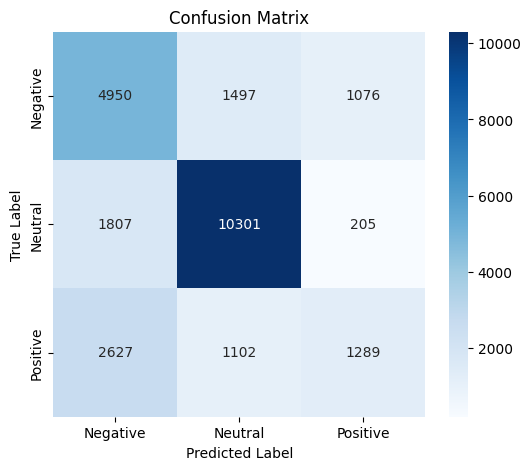

In [26]:
# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [27]:
# Display classification report
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

    Negative       0.53      0.66      0.59      7523
     Neutral       0.80      0.84      0.82     12313
    Positive       0.50      0.26      0.34      5018

    accuracy                           0.67     24854
   macro avg       0.61      0.58      0.58     24854
weighted avg       0.66      0.67      0.65     24854



F1 score for positive is much less than for negative and neutral. It is because of the sampled imbalanced dataset. So it is better to train the saved model on the more balanced dataset, with more proportionate representation. Also optional is to use in data some percent of data that model saw during training because it other way model could forget the data on which it was trained on. So let's try to train the model on the more balanced dataset and check the results.

## Improve the model with more balanced dataset

In [ ]:
data = pd.read_csv('../../data/Multiilingual_dataset/mulilingual_dataset.csv').dropna()

In [ ]:
label_1_data = data[data["label"] == 1.0].sample(n=385982, random_state=42)
label_0_data = data[data["label"] == 0.0].sample(n=318423, random_state=42)
label_2_data = data[data["label"] == 2.0].sample(n=332501, random_state=42)

data_final = pd.concat([label_1_data, label_0_data, label_2_data])
data_final = data_final.sample(frac=1, random_state=42).reset_index(drop=True)
data_final["label"].value_counts()

label
1.0    385982
2.0    332501
0.0    318423
Name: count, dtype: int64

In [ ]:
# Split data into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data_final["text"].tolist(), data_final["label"].tolist(), test_size=0.2, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, ignore_mismatched_sizes=True) 

In [ ]:
def tokenize_function(texts):
    tokenized_texts = []
    for text in tqdm(texts, desc="Tokenizing Texts", unit="text"):
        tokenized_texts.append(tokenizer(text, truncation=True, padding="max_length", max_length=128))
    return {key: [dic[key] for dic in tokenized_texts] for key in tokenized_texts[0]}  
    
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)
test_encodings = tokenize_function(test_texts)

Tokenizing Texts: 100%|██████████| 103691/103691 [00:36<00:00, 2863.82text/s]


In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)  
        return item

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    "/kaggle/working/kaggle/working/model5", num_labels=3, ignore_mismatched_sizes=True
)
model.to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

num_epochs = 3
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs
)


In [ ]:
from sklearn.metrics import classification_report, f1_score
def train_model():
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, desc="Training", leave=True)
    for batch in loop:
        optimizer.zero_grad()

        # Move data to GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return total_loss / len(train_loader)

def evaluate_model():
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        loop = tqdm(val_loader, desc="Validating", leave=True)
        for batch in loop:
            # Move data to GPU
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()

            # Compute predictions
            preds = torch.argmax(outputs.logits, dim=1)

            # Store predictions and labels for F1-score calculation
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item())

    accuracy = correct / total

    # Calculate F1-score for each class
    report = classification_report(all_labels, all_preds, digits=4, output_dict=True)
    f1_scores = {f"F1-score class {cls}": report[str(cls)]["f1-score"] for cls in range(3)}

    return total_loss / len(val_loader), accuracy, f1_scores

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train_model()
    val_loss, val_acc, f1_scores = evaluate_model()
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")
    print("F1 Scores per class:", f1_scores)

Epoch 1/3


Validating: 100%|██████████| 3241/3241 [03:02<00:00, 17.74it/s, loss=0.896]


Train Loss: 0.5582 | Val Loss: 0.6196 | Val Accuracy: 0.7230
F1 Scores per class: {'F1-score class 0': 0.6636933504240488, 'F1-score class 1': 0.7496899768156575, 'F1-score class 2': 0.7412090290256154}
Epoch 2/3


Validating: 100%|██████████| 3241/3241 [03:02<00:00, 17.78it/s, loss=1.08] 


Train Loss: 0.4590 | Val Loss: 0.6469 | Val Accuracy: 0.7254
F1 Scores per class: {'F1-score class 0': 0.6637622365287944, 'F1-score class 1': 0.7594553308048883, 'F1-score class 2': 0.7374884616928202}
Epoch 3/3


Validating: 100%|██████████| 3241/3241 [03:02<00:00, 17.74it/s, loss=1.08] 


Train Loss: 0.4083 | Val Loss: 0.6469 | Val Accuracy: 0.7254
F1 Scores per class: {'F1-score class 0': 0.6637622365287944, 'F1-score class 1': 0.7594553308048883, 'F1-score class 2': 0.7374884616928202}


In [ ]:
# ✅ Step 9: Save Fine-Tuned Model
model.save_pretrained("/kaggle/working/model_phase2")
tokenizer.save_pretrained("/kaggle/working/model_phase2")

print("🔥 Fine-tuning completed! Model saved to /kaggle/working/model_phase2 🔥")

🔥 Fine-tuning completed! Model saved to /kaggle/working/model_phase2 🔥


In [ ]:
def test_model():
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, digits=4)
    print("Test Set Performance:")
    print(report)

# Run final test evaluation
test_model()

Testing: 100%|██████████| 3241/3241 [02:57<00:00, 18.26it/s]


Test Set Performance:
              precision    recall  f1-score   support

           0     0.7545    0.5867    0.6601     31835
           1     0.7723    0.7470    0.7594     38547
           2     0.6624    0.8284    0.7362     33309

    accuracy                         0.7239    103691
   macro avg     0.7298    0.7207    0.7186    103691
weighted avg     0.7315    0.7239    0.7215    103691



Accuracy incrases from 0.67 to 0.72, f1-score also increases from 0.57 to 0.72, so balancing the dataset helped to improve the model.